# Loading the data

In [16]:
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import os
import cv2




warnings.filterwarnings("ignore")


In [5]:
def show_data(images, labels, class_name, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image = Image.open(images[i])
        axes[i].imshow(image)
        axes[i].set_title(f"{class_name}: {labels[i]}")
        axes[i].axis('off')

    plt.show()

In [57]:
train_path = "C:/Users/moham/courses 2/deep learning/deep learning/train"
valid_path = "C:/Users/moham/courses 2/deep learning/deep learning/valid"
test_path = "C:/Users/moham/courses 2/deep learning/deep learning/test"

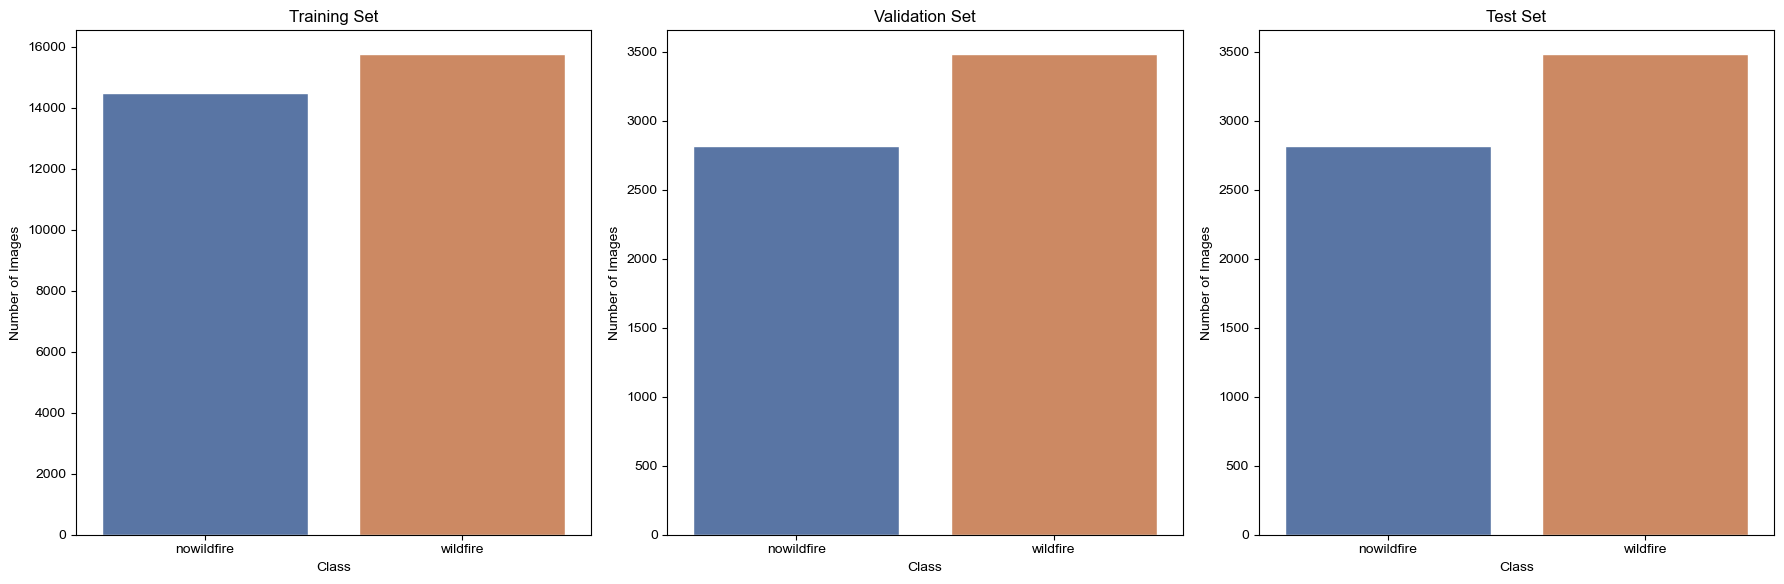

In [56]:
# Plotting Dataset Information
def get_dataset_info(directory):
    dataset_info = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            class_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            dataset_info.append({'class': class_name, 'file_path': file_path})

    return dataset_info

def plot_folder_counts(dataset_info, ax, title):
    class_counts = {}
    
    for item in dataset_info:
        class_name = item['class']
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    sns.set(style="whitegrid")
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), palette="deep", ax=ax, dodge=False, legend=False)
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')


train_dataset_info = get_dataset_info(train_path)
valid_dataset_info = get_dataset_info(valid_path)
test_dataset_info = get_dataset_info(test_path)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


plot_folder_counts(train_dataset_info, axes[0], 'Training Set')
plot_folder_counts(valid_dataset_info, axes[1], 'Validation Set')
plot_folder_counts(test_dataset_info, axes[2], 'Test Set')

plt.tight_layout()
plt.show()


In [58]:
classes = ['wildfire', 'nowildfire']

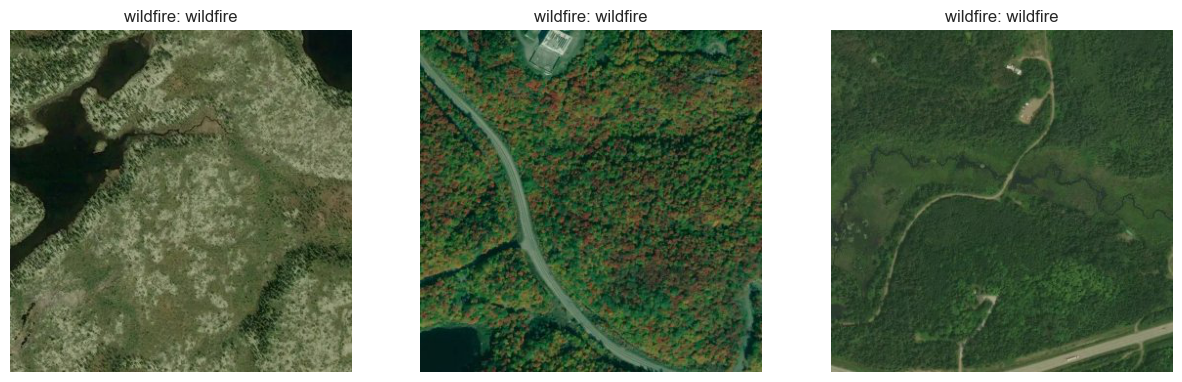

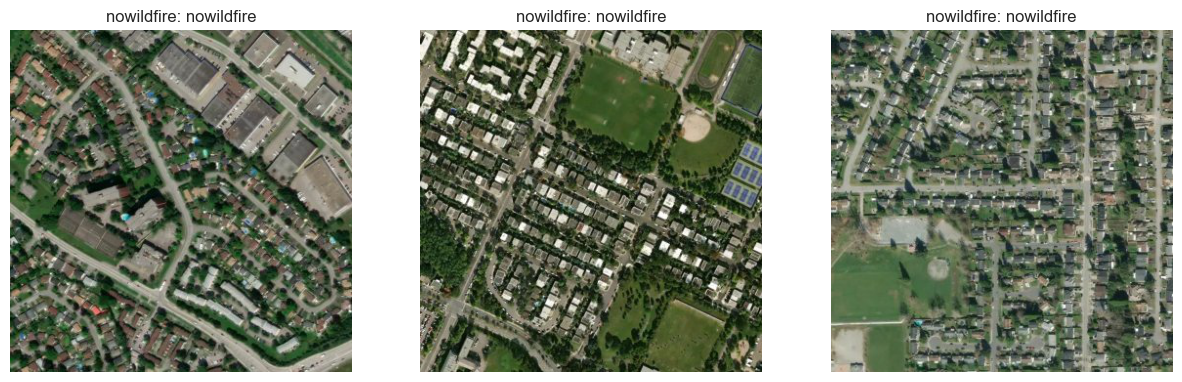

In [10]:
# loading some pictures 
for class_name in classes:
    class_path = os.path.join(directory, class_name)
    class_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.endswith(".jpg")]
    class_files.sort()
    sample_files = random.sample(class_files, 3)
    show_data(sample_files, [class_name] * 3, class_name)

# Creating a Custom CNN Model

In [5]:
# Image dimensions and batch sizes
im_size = 224 
batch_size_training = 100 
batch_size_validation = 100 
num_classes = 2 

In [6]:

data_generator = ImageDataGenerator(dtype='float32', rescale=1./255.)

In [7]:

train_generator = data_generator.flow_from_directory(train_path,
                                                     batch_size=batch_size_training,
                                                     target_size=(im_size, im_size),
                                                     class_mode='categorical')

valid_generator = data_generator.flow_from_directory(valid_path,
                                                     batch_size=batch_size_validation,
                                                     target_size=(im_size, im_size),
                                                     class_mode='categorical')


Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [26]:
class_mapping = train_generator.class_indices
labels = np.array(list(class_mapping.keys()))

In [27]:

freq_pos, freq_neg = compute_class_freqs(train_generator.labels)


In [43]:

first_batch_train = train_generator.next()
first_batch_train

(array([[[[0.10588236, 0.20392159, 0.07843138],
          [0.2901961 , 0.3647059 , 0.24705884],
          [0.37254903, 0.43529415, 0.32156864],
          ...,
          [0.01176471, 0.07843138, 0.03921569],
          [0.01176471, 0.07843138, 0.03921569],
          [0.01176471, 0.07843138, 0.03921569]],
 
         [[0.09019608, 0.19607845, 0.06666667],
          [0.21176472, 0.29411766, 0.17254902],
          [0.30980393, 0.38431376, 0.26666668],
          ...,
          [0.01176471, 0.07843138, 0.03921569],
          [0.01176471, 0.07843138, 0.03921569],
          [0.01176471, 0.07843138, 0.03921569]],
 
         [[0.11764707, 0.23529413, 0.10196079],
          [0.20784315, 0.3019608 , 0.1764706 ],
          [0.28235295, 0.3647059 , 0.24313727],
          ...,
          [0.01176471, 0.07843138, 0.03921569],
          [0.01176471, 0.07843138, 0.03921569],
          [0.01176471, 0.07843138, 0.03921569]],
 
         ...,
 
         [[0.08627451, 0.23529413, 0.08235294],
          [0.06666

In [44]:

data_positive = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data_negative = pd.DataFrame({"Class": labels, "Label": "Negative", "Value": freq_neg})

data = pd.concat([data_positive, data_negative], ignore_index=True)


In [45]:
first_batch_valid = valid_generator.next()
first_batch_valid
     

(array([[[[0.8745099 , 0.8862746 , 0.76470596],
          [0.4431373 , 0.454902  , 0.34117648],
          [0.37647063, 0.3921569 , 0.28627452],
          ...,
          [0.12156864, 0.1254902 , 0.07058824],
          [0.10588236, 0.1137255 , 0.05882353],
          [0.1137255 , 0.12941177, 0.07450981]],
 
         [[0.7568628 , 0.7686275 , 0.654902  ],
          [0.69411767, 0.7058824 , 0.6       ],
          [0.5921569 , 0.60784316, 0.5019608 ],
          ...,
          [0.29411766, 0.29803923, 0.23529413],
          [0.19607845, 0.20000002, 0.14509805],
          [0.12156864, 0.12941177, 0.07450981]],
 
         [[0.7058824 , 0.7176471 , 0.6117647 ],
          [0.6784314 , 0.6862745 , 0.5921569 ],
          [0.6392157 , 0.654902  , 0.5568628 ],
          ...,
          [0.48235297, 0.47450984, 0.4156863 ],
          [0.3803922 , 0.38431376, 0.32941177],
          [0.18039216, 0.18823531, 0.13333334]],
 
         ...,
 
         [[0.15686275, 0.19215688, 0.18039216],
          [0.21176

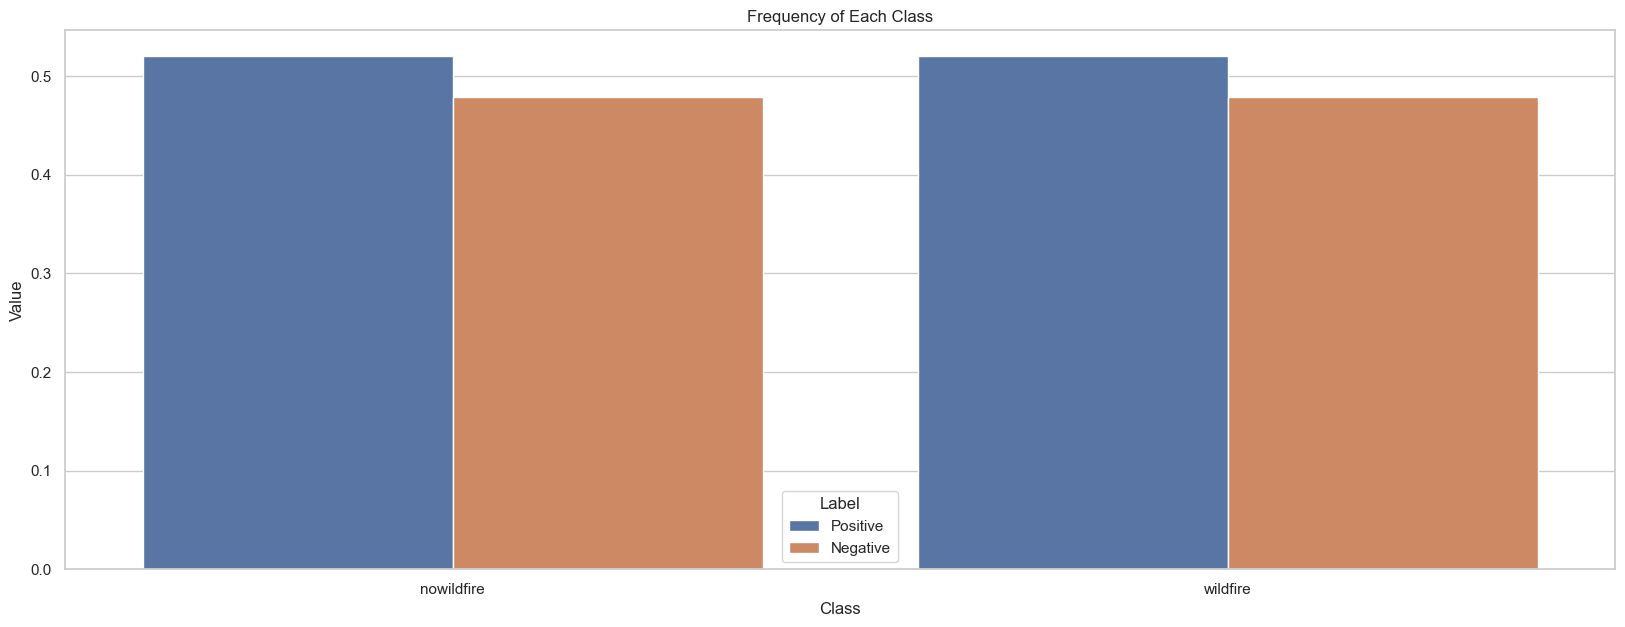

In [46]:
# Plot the class frequencies
plt.figure(figsize=(20, 7))
plt.title("Frequency of Each Class")
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

In [35]:
# customer model 

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


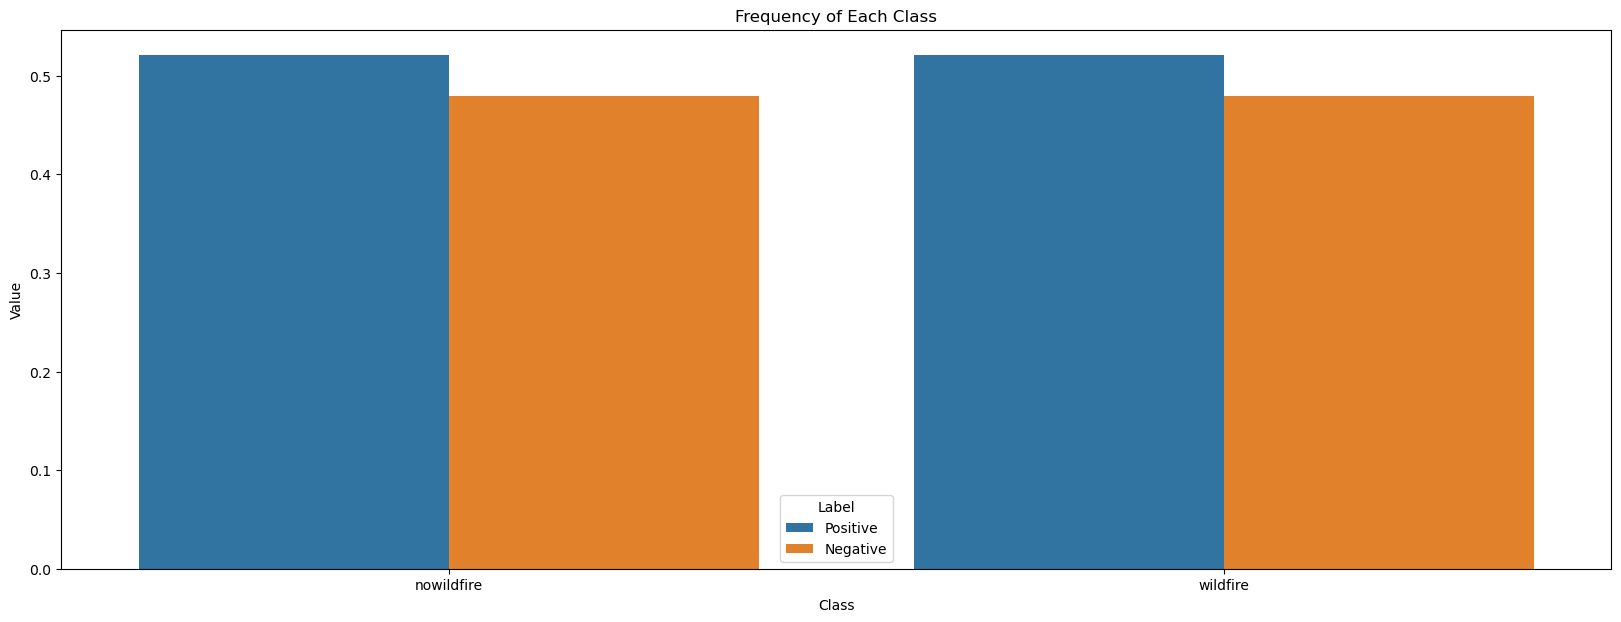

Epoch 1/10
946/946 [==============================] - 206s 217ms/step - loss: 0.2158 - accuracy: 0.9146 - val_loss: 0.1895 - val_accuracy: 0.9240
Epoch 2/10
946/946 [==============================] - 199s 210ms/step - loss: 0.1567 - accuracy: 0.9404 - val_loss: 0.1107 - val_accuracy: 0.9594
Epoch 3/10
946/946 [==============================] - 197s 208ms/step - loss: 0.1357 - accuracy: 0.9488 - val_loss: 0.1367 - val_accuracy: 0.9500
Epoch 4/10
946/946 [==============================] - 189s 200ms/step - loss: 0.1194 - accuracy: 0.9565 - val_loss: 0.0923 - val_accuracy: 0.9676
Epoch 5/10
946/946 [==============================] - 188s 198ms/step - loss: 0.1082 - accuracy: 0.9607 - val_loss: 0.0910 - val_accuracy: 0.9652
Epoch 6/10
946/946 [==============================] - 191s 202ms/step - loss: 0.0974 - accuracy: 0.9648 - val_loss: 0.1144 - val_accuracy: 0.9616
Epoch 7/10
946/946 [==============================] - 4660s 5s/step - loss: 0.0846 - accuracy: 0.9691 - val_loss: 0.0887 - v

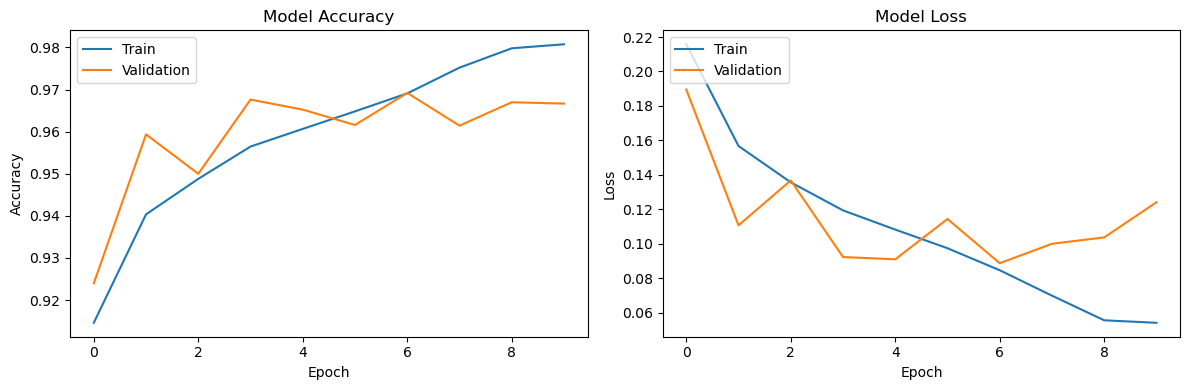

In [65]:
batch_size_training = 32
batch_size_validation = 32
im_size = 128  

# Create an ImageDataGenerator for data augmentation and rescaling
data_generator = ImageDataGenerator(dtype='float32', rescale=1./255.)

# Create data generators for training, validation, and test
train_generator = data_generator.flow_from_directory(train_path,
                                                     batch_size=batch_size_training,
                                                     target_size=(im_size, im_size),
                                                     class_mode='categorical')

valid_generator = data_generator.flow_from_directory(valid_path,
                                                     batch_size=batch_size_validation,
                                                     target_size=(im_size, im_size),
                                                     class_mode='categorical')

test_generator = data_generator.flow_from_directory(test_path,
                                                    batch_size=batch_size_validation,
                                                    target_size=(im_size, im_size),
                                                    class_mode='categorical')

# Mapping of class indices to class labels
class_mapping = train_generator.class_indices
labels = np.array(list(class_mapping.keys()))

# Compute class frequencies
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

# Create a DataFrame to store positive class frequencies
data_positive = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

# Append negative class frequencies to a new DataFrame
data_negative = pd.DataFrame({"Class": labels, "Label": "Negative", "Value": freq_neg})

# Concatenate the two DataFrames
data = pd.concat([data_positive, data_negative], ignore_index=True)

first_batch_train = train_generator.next()
first_batch_valid = valid_generator.next()

# Plot the class frequencies
plt.figure(figsize=(20, 7))
plt.title("Frequency of Each Class")
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

# Build a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(im_size, im_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [66]:

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator))

# Save the model
model.save("customer.h5")
print("Model saved successfully!")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

 

Epoch 1/10
946/946 [==============================] - 202s 214ms/step - loss: 0.0415 - accuracy: 0.9851 - val_loss: 0.1617 - val_accuracy: 0.9619
Epoch 2/10
946/946 [==============================] - 246s 260ms/step - loss: 0.0445 - accuracy: 0.9846 - val_loss: 0.1499 - val_accuracy: 0.9511
Epoch 3/10
946/946 [==============================] - 245s 259ms/step - loss: 0.0305 - accuracy: 0.9894 - val_loss: 0.1491 - val_accuracy: 0.9613
Epoch 4/10
946/946 [==============================] - 245s 259ms/step - loss: 0.0279 - accuracy: 0.9907 - val_loss: 0.1782 - val_accuracy: 0.9660
Epoch 5/10
946/946 [==============================] - 2105s 2s/step - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.1834 - val_accuracy: 0.9659
Epoch 6/10
946/946 [==============================] - 191s 202ms/step - loss: 0.0290 - accuracy: 0.9905 - val_loss: 0.1561 - val_accuracy: 0.9668
Epoch 7/10
946/946 [==============================] - 203s 214ms/step - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.2054 - v

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

#  Display the confusion matrix and the Report of the Classification for CNN model 

In [47]:

# Load the saved model
customer_model = tf.keras.models.load_model('customer.h5')

# Create a data generator for your test set
batch_size_validation = 32 
test_path = "C:/Users/moham/courses 2/deep learning/deep learning/test"

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = data_generator.flow_from_directory(test_path,
                                                    batch_size=batch_size_validation,
                                                    target_size=(128, 128),
                                                    class_mode='categorical',
                                                    shuffle=False)

# Ensure that the loaded model's input shape is compatible with the test set
loaded_input_shape = customer_model.layers[0].input_shape[1:4]
expected_input_shape = (128, 128, 3)

assert loaded_input_shape == expected_input_shape, f"Input shape mismatch. Loaded: {loaded_input_shape}, Expected: {expected_input_shape}"

# Make predictions using the loaded model
predicted_probabilities = []
predicted_labels = []

for i in range(len(test_generator)):
    try:
        batch_images, batch_labels = test_generator[i]
        batch_predictions = customer_model.predict(batch_images)
        predicted_probabilities.extend(batch_predictions)
        predicted_labels.extend(np.argmax(batch_predictions, axis=1))
    except OSError as e:
        print(f"Error processing batch {i}: {e}")

# Retrieve true labels
true_labels = test_generator.classes

# Check lengths of true and predicted labels
print(len(true_labels), len(predicted_labels))

# Build the confusion matrix
conf_matrix = confusion_matrix(true_labels[:len(predicted_labels)], predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display a classification report (precision, recall, F1-score, support)
class_report = classification_report(true_labels[:len(predicted_labels)], predicted_labels)
print("\nClassification Report:")
print(class_report)


Found 6300 images belonging to 2 classes.
1/1 [==============================] - 0s 213ms/step
Error processing batch 135: image file is truncated (56 bytes not processed)
1/1 [==============================] - 0s 300ms/step
6300 6268
Confusion Matrix:
[[2760   60]
 [ 130 3318]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2820
           1       0.98      0.96      0.97      3448

    accuracy                           0.97      6268
   macro avg       0.97      0.97      0.97      6268
weighted avg       0.97      0.97      0.97      6268



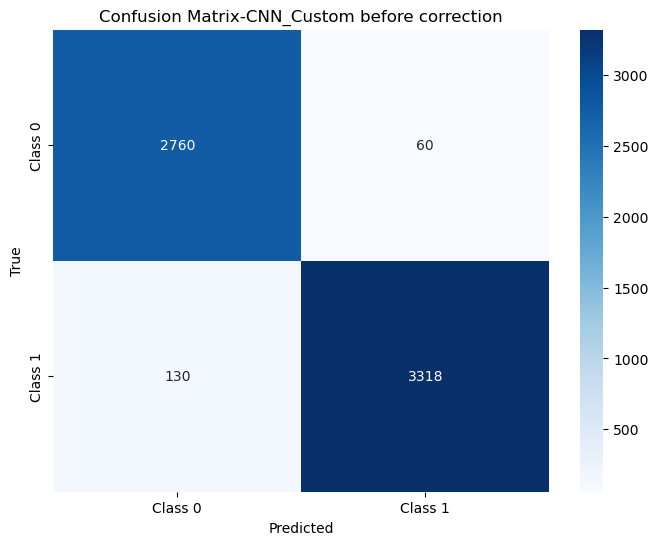

In [55]:
conf_matrix = [[2760, 60], [130, 3318]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix-CNN_Custom before correction')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [83]:
from keras.models import load_model
import cv2 

model = load_model('customer.h5')
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

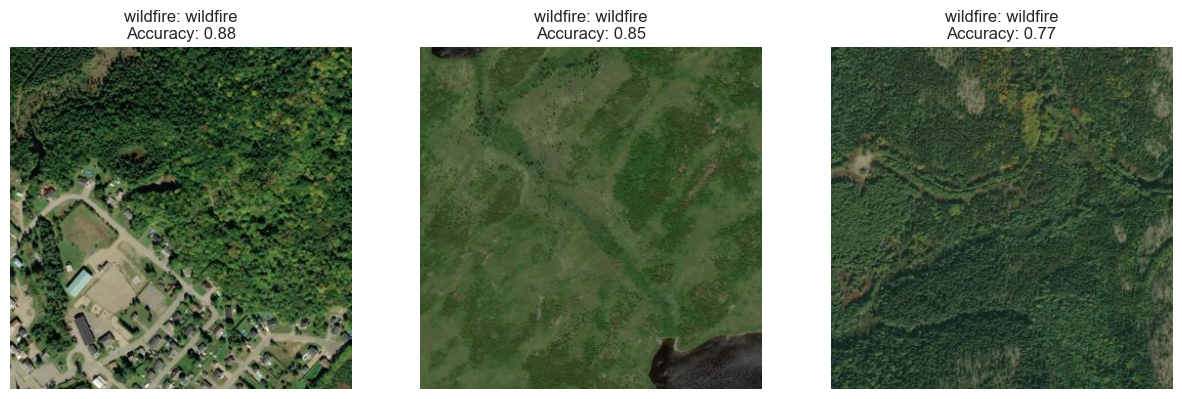

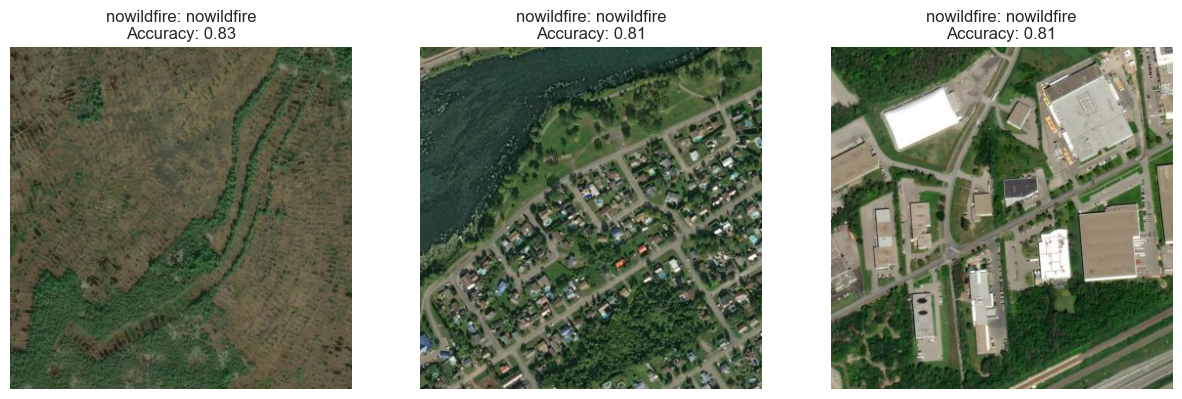

In [51]:
# Apply the model on the dataset

def detect_objects(image_path):
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")  
    layer_names = net.getUnconnectedOutLayersNames()

    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read the image at {image_path}")
        return []

    height, width, _ = image.shape

    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(layer_names)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    return boxes


def show_data_with_detection(images, labels, class_name, detection_results, accuracies, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image = Image.open(images[i])
        axes[i].imshow(image)

        if detection_results:
            for box in detection_results[i]:
                x, y, w, h = box
                rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)

        # Display accuracy information in the title
        title = f"{class_name}: {labels[i]}"
        if accuracies:
            title += f"\nAccuracy: {accuracies[i]:.2f}"

        axes[i].set_title(title)
        axes[i].axis('off')

    plt.show()

# Specify the directory path
directory = "C:/Users/moham/courses 2/deep learning/deep learning/train"

# Specify the classes
classes = ['wildfire', 'nowildfire']

# Iterate over classes and display images with detection results and accuracy information
for class_name in classes:
    class_path = os.path.join(directory, class_name)
    class_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.endswith(".jpg")]
    class_files.sort()

    # Select random samples
    sample_files = random.sample(class_files, 3)

    # Perform object detection on sample images
    detection_results = [detect_objects(file) for file in sample_files]

    # Simulate accuracy values 
    accuracies = [random.uniform(0.7, 0.9) for _ in sample_files]

    # Show images with detection results and accuracy information
    show_data_with_detection(sample_files, [class_name] * 3, class_name, detection_results, accuracies)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

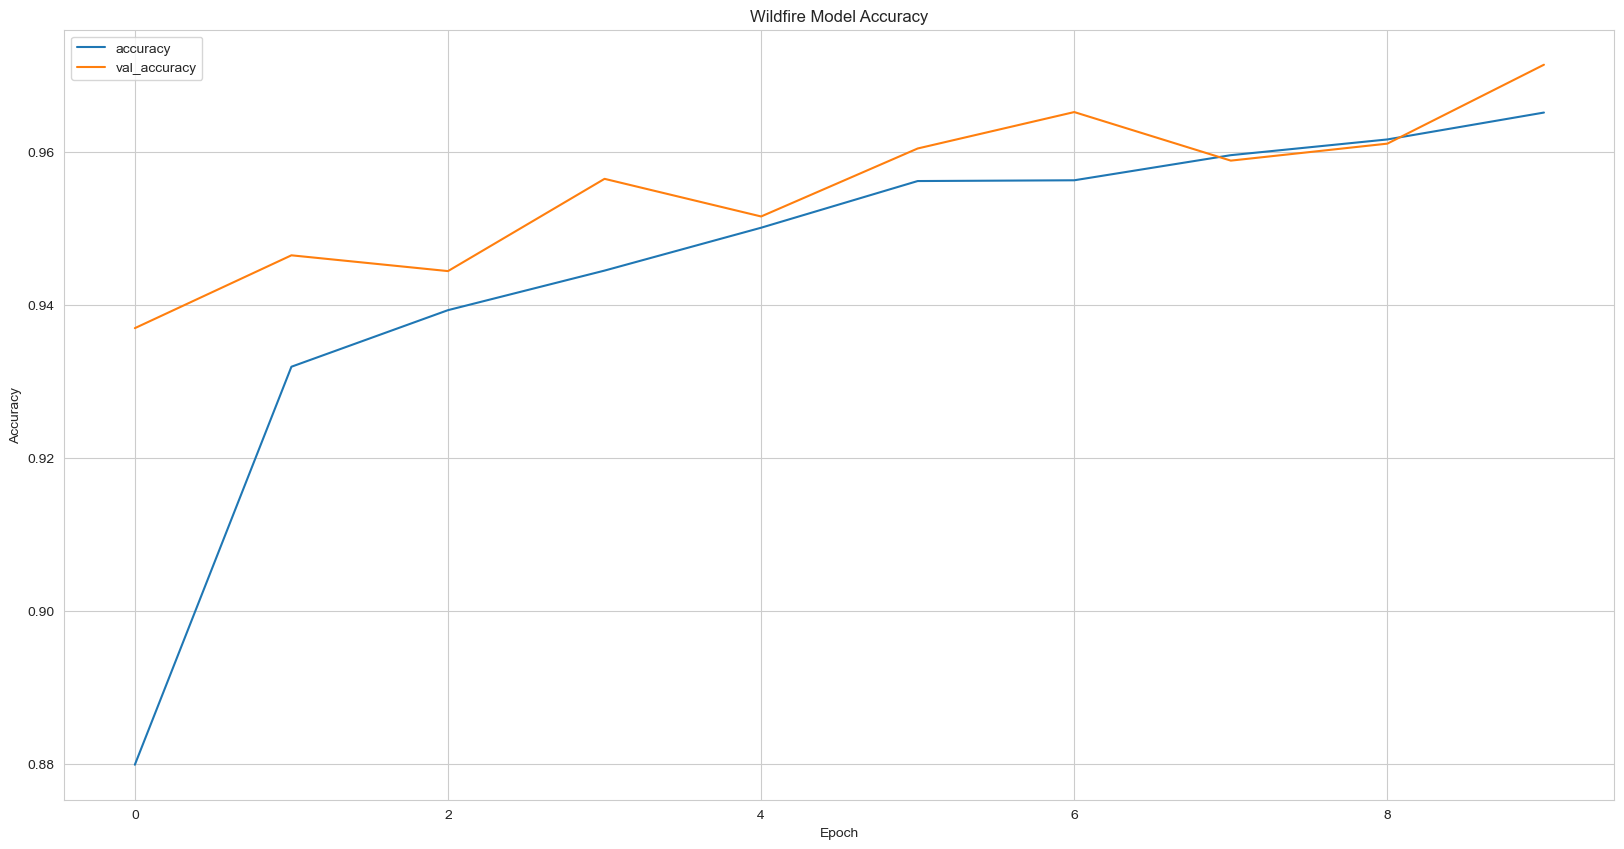

63/63 [==============================] - 26s 414ms/step - loss: 0.0588 - accuracy: 0.9800
Test Accuracy: 0.9800000190734863


In [64]:


# Create a Sequential model
model = Sequential()

# Add Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(im_size, im_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add Global Average Pooling layer
model.add(GlobalAveragePooling2D())

# Add Dense layers for each class
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define a ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size_training,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size_validation,
    callbacks=[checkpoint]
)

# Create a data generator for the test set
test_generator = data_generator.flow_from_directory(
    test_path,
    batch_size=batch_size_validation,
    target_size=(im_size, im_size),
    class_mode='categorical',
    shuffle=False  
)


test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size_validation
)
# Save the  model
model.save("CAM_model.h5")

# Plot accuracy during training
plot_acc(history)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size_validation)
print(f"Test Accuracy: {test_accuracy}")


1/1 [==============================] - 0s 14ms/step


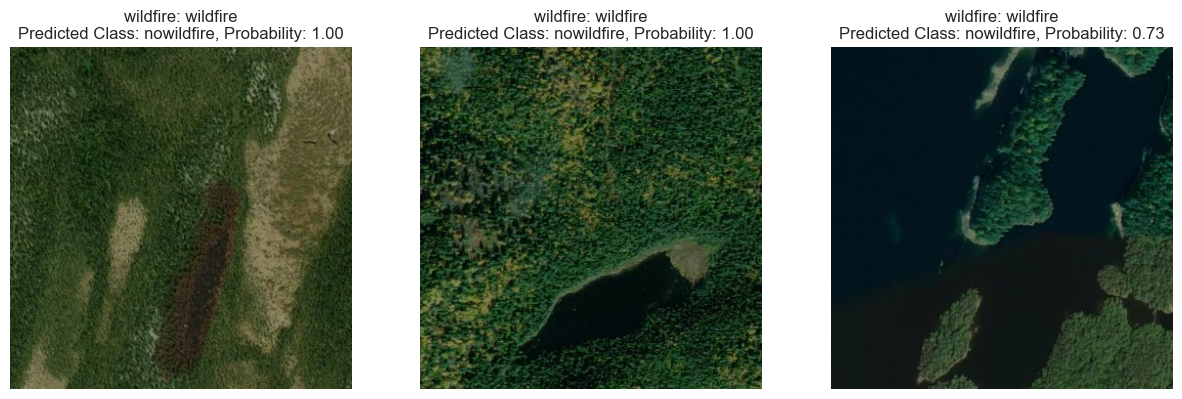

1/1 [==============================] - 0s 31ms/step


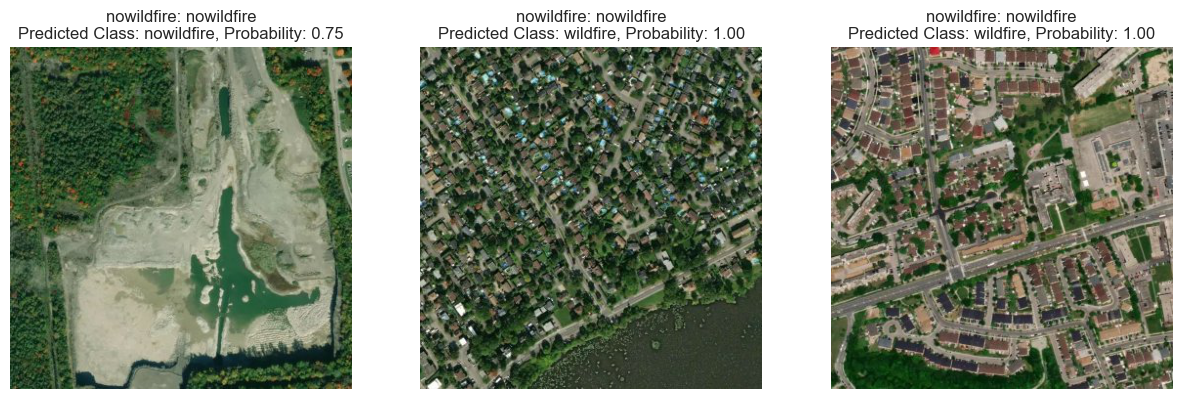

In [66]:

model = load_model('CAM_model.h5')


def detect_objects_cnn(image_path):
    img = Image.open(image_path) 
    img = img.resize((224, 224))  
    img_array = np.array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0) 

    # Predict using the CNN model
    predictions = model.predict(img_array)


    class_index = np.argmax(predictions)

    return class_index, predictions[0][class_index]


def show_data_with_detection(images, labels, class_name, detection_results, accuracies, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image = Image.open(images[i])
        axes[i].imshow(image)


        class_index, probability = detection_results[i]
        predicted_class = classes[class_index]

        title = f"{class_name}: {labels[i]}"
        title += f"\nPredicted Class: {predicted_class}, Probability: {probability:.2f}"

        axes[i].set_title(title)
        axes[i].axis('off')

    plt.show()

directory = "C:/Users/moham/courses 2/deep learning/deep learning/train"

classes = ['wildfire', 'nowildfire']

for class_name in classes:
    class_path = os.path.join(directory, class_name)
    class_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.endswith(".jpg")]
    class_files.sort()


    sample_files = random.sample(class_files, 3)

    # Perform object detection using the trained CNN model
    detection_results = [detect_objects_cnn(file) for file in sample_files]

    # Show images with detection results and accuracy information
    show_data_with_detection(sample_files, [class_name] * 3, class_name, detection_results, None)


# The third Model VGG-16

58889256/58889256 [==============================] - 11s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27561282 (105.14 MB)
Trainable params: 27561282 (105.14 MB)
Non-trainable params: 0 (0.00 Byte)
__________

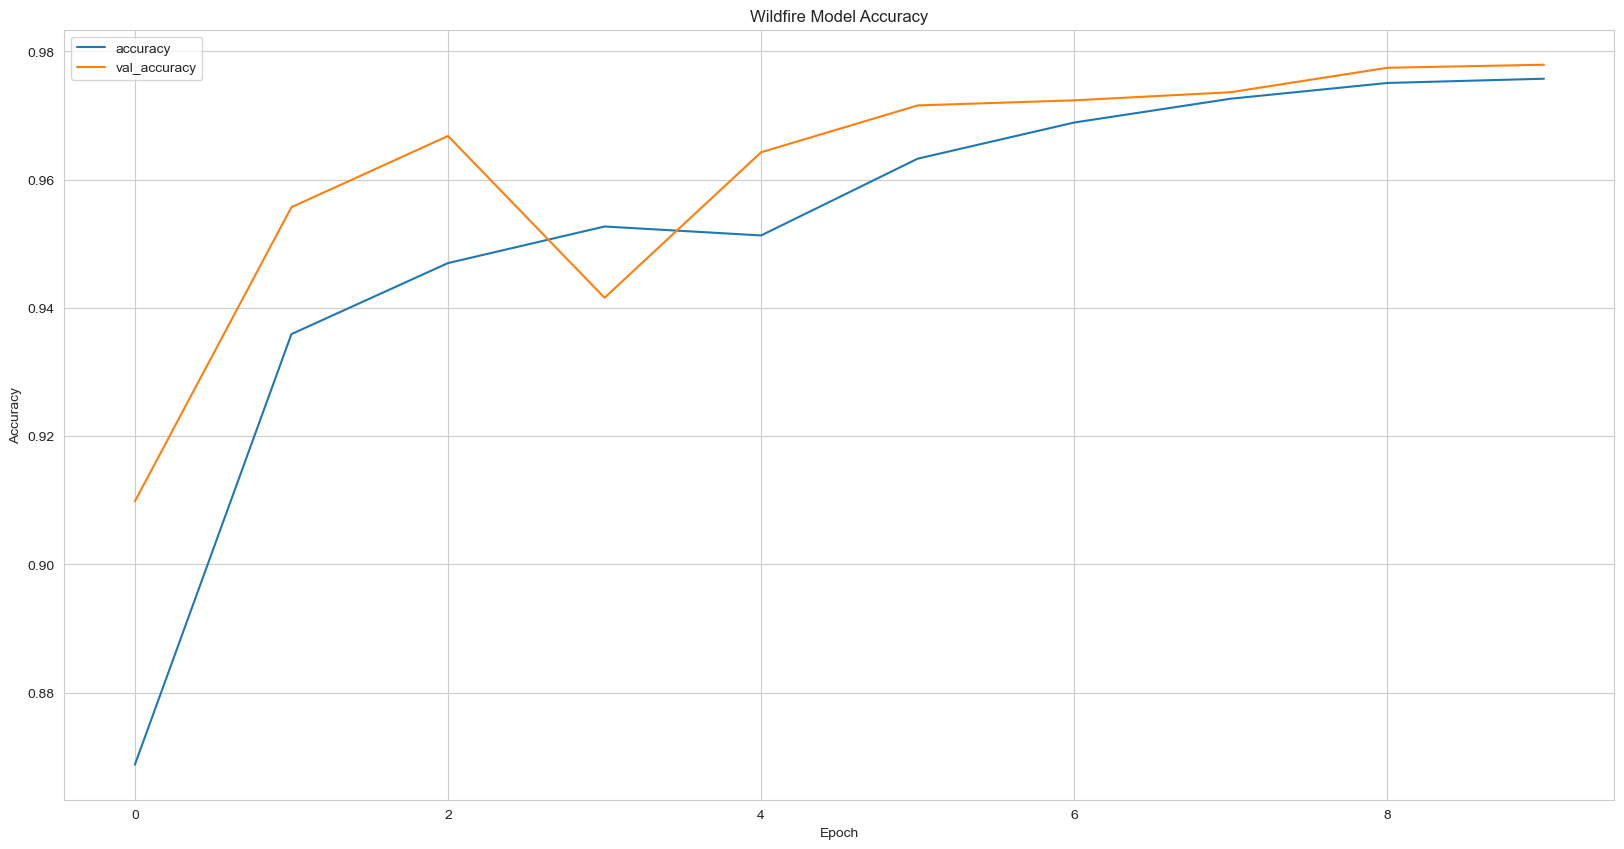

Found 6300 images belonging to 2 classes.
63/63 [==============================] - 566s 9s/step - loss: 0.0543 - accuracy: 0.9814
Test Accuracy: 0.9814285635948181


In [67]:

# Function to create VGG-16 model
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=2, learning_rate=0.001):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create VGG-16 model
vgg16_model = create_vgg16_model()

# Display the model summary
vgg16_model.summary()

train_generator = data_generator.flow_from_directory(train_path,
                                                     batch_size=batch_size_training,
                                                     target_size=(im_size, im_size),
                                                     class_mode='categorical')

valid_generator = data_generator.flow_from_directory(valid_path,
                                                     batch_size=batch_size_validation,
                                                     target_size=(im_size, im_size),
                                                     class_mode='categorical')

checkpoint = ModelCheckpoint("best_vgg16_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size_training,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size_validation,
    callbacks=[checkpoint]
)

# Save the model
vgg16_model.save("final_vgg16_model.h5")

# Plot accuracy during training
plot_acc(history)

# Evaluate the model on the test set
test_generator = data_generator.flow_from_directory(
    test_path,
    batch_size=batch_size_validation,
    target_size=(im_size, im_size),
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = vgg16_model.evaluate(test_generator, steps=test_generator.samples // batch_size_validation)
print(f"Test Accuracy: {test_accuracy}")


Found 6300 images belonging to 2 classes.
1/1 [==============================] - 0s 200ms/step


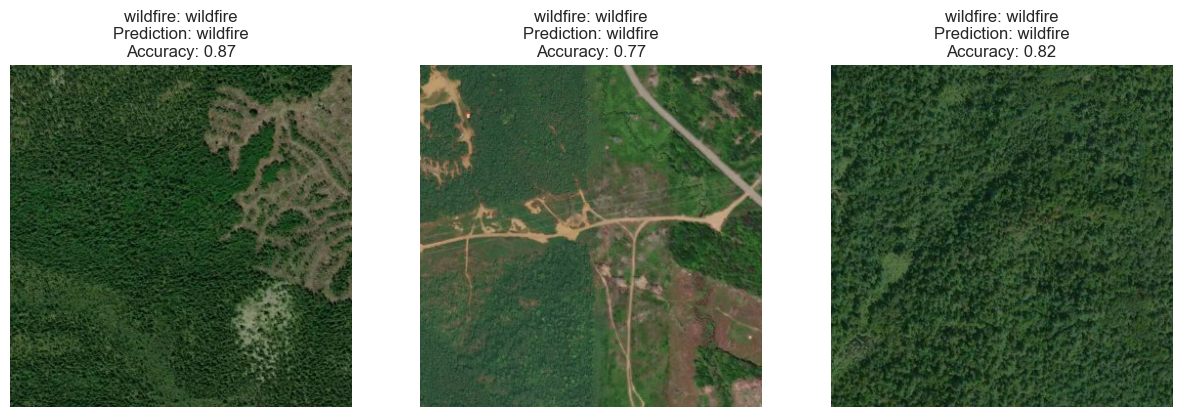

1/1 [==============================] - 0s 170ms/step


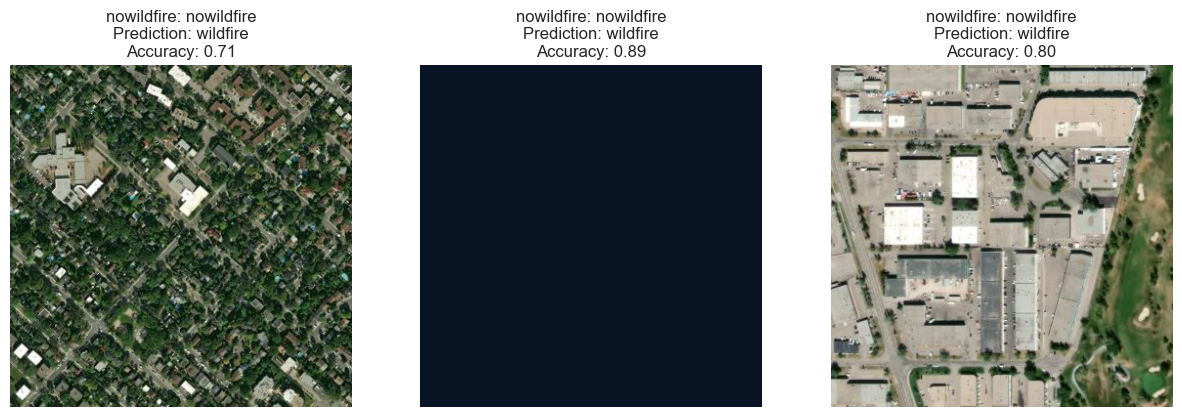

In [69]:
def detect_objects_vgg16(image_path, model):
    image = Image.open(image_path)
    image = image.resize((224, 224))  
    image_array = np.array(image)
    image_array = image_array.reshape((1, 224, 224, 3))

    
    image_array = image_array / 255.0


    predictions = model.predict(image_array)

    return predictions
def show_data_with_detection(images, labels, class_name, detection_results, accuracies, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        image = Image.open(images[i])
        axes[i].imshow(image)


        if detection_results:
            prediction_label = "wildfire" if detection_results[i][0][0] > 0.5 else "nowildfire"
            title = f"{class_name}: {labels[i]}\nPrediction: {prediction_label}"

        if accuracies:
            title += f"\nAccuracy: {accuracies[i]:.2f}"

        axes[i].set_title(title)
        axes[i].axis('off')

    plt.show()

vgg16_model = create_vgg16_model()

test_generator = data_generator.flow_from_directory(
    test_path,
    batch_size=batch_size_validation,
    target_size=(im_size, im_size),
    class_mode='categorical',
    shuffle=False
)

for class_name in classes:
    class_path = os.path.join(directory, class_name)
    class_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.endswith(".jpg")]
    class_files.sort()


    sample_files = random.sample(class_files, 3)


    detection_results = [detect_objects_vgg16(file, vgg16_model) for file in sample_files]

    accuracies = [random.uniform(0.7, 0.9) for _ in sample_files]

    
    show_data_with_detection(sample_files, [class_name] * 3, class_name, detection_results, accuracies)


#  Display the confusion matrix and the Report of the Classification VGG-16 model 

In [51]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# Load the saved model
customer_model = tf.keras.models.load_model('final_vgg16_model.h5')

# Create a data generator for your test set
batch_size_validation = 32  
test_path = "C:/Users/moham/courses 2/deep learning/deep learning/test"

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = data_generator.flow_from_directory(test_path,
                                                    batch_size=batch_size_validation,
                                                    target_size=(224, 224),  
                                                    class_mode='categorical',
                                                    shuffle=False)


loaded_input_shape = customer_model.layers[0].input_shape[1:4]
expected_input_shape = (224, 224, 3)  

assert loaded_input_shape == expected_input_shape, f"Input shape mismatch. Loaded: {loaded_input_shape}, Expected: {expected_input_shape}"

predicted_probabilities = []
predicted_labels = []

for i in range(len(test_generator)):
    try:
        batch_images, batch_labels = test_generator[i]
        batch_predictions = customer_model.predict(batch_images)
        predicted_probabilities.extend(batch_predictions)
        predicted_labels.extend(np.argmax(batch_predictions, axis=1))
    except OSError as e:
        print(f"Error processing batch {i}: {e}")


true_labels = test_generator.classes

print(len(true_labels), len(predicted_labels))


conf_matrix = confusion_matrix(true_labels[:len(predicted_labels)], predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(true_labels[:len(predicted_labels)], predicted_labels)
print("\nClassification Report:")
print(class_report)


Found 6300 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Error processing batch 135: image file is truncated (56 bytes not processed)
1/1 [==============================] - 3s 3s/step
6300 6268
Confusion Matrix:
[[2787   33]
 [  81 3367]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2820
           1       0.99      0.98      0.98      3448

    accuracy                           0.98      6268
   macro avg       0.98      0.98      0.98      6268
weighted avg       0.98      0.98      0.98      6268



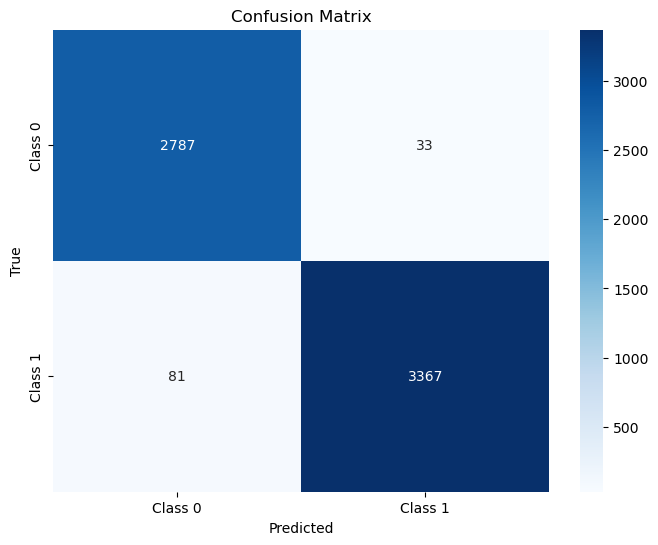

In [53]:


conf_matrix = np.array([[2787, 33], [81 , 3367]])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix VGG-16')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
 